In [ ]:
# 파일이름  : TimeSeriesDataGenerator.ipynb
# 코드설명  : 시계열 특성(추세, 계절성, 정상성)을 갖는 데이터 생성
# 입/출력   : 기간(st_time, ed_time), 시간 단위(t_unit), 시간 세분 정도(t_granuality), 최소/최대값(min_val/max_val) / 데이터 세트
# 최종수정  : 2023년 12월 04일
# 제 작 자  : 홍민성 (mshong@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [2]:
from datetime import timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mockseries.trend import ExponentialTrend, FlatTrend, LinearTrend
from mockseries.seasonality import DailySeasonality, WeeklySeasonality, YearlySeasonality, SinusoidalSeasonality
from mockseries.noise import RedNoise
from mockseries.utils import datetime_range
from mockseries.utils.timedeltas import JANUARY, MARCH, JUNE, JULY, AUGUST, SEPTEMBER, OCTOBER, DECEMBER

In [59]:
# 데이터 값의 범위 조정 모듈
def minMaxScaler(data, min_val, max_val):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (max_val - min_val) + min_val

# 각 시간별 시계열 데이터 생성
def get_ts_data_df(timeseries_, min_val, max_val, t_unit, t_granularity, st_time, ed_time):
    # t_unit : 'microseconds','milliseconds','seconds','minutes','hours','days'
    ts_data_df = pd.DataFrame()
    if t_unit == 'microseconds':
        granularity_unit=timedelta(microseconds=t_granularity)
    elif t_unit == 'milliseconds':
        granularity_unit=timedelta(milliseconds=t_granularity)
    elif t_unit == 'seconds':
        granularity_unit=timedelta(seconds=t_granularity)
    elif t_unit == 'minutes':
        granularity_unit=timedelta(minutes=t_granularity)
    elif t_unit == 'hours':
        granularity_unit=timedelta(hours=t_granularity)
    elif t_unit == 'days':
        granularity_unit=timedelta(days=t_granularity)
    else :
        raise Exception("Sorry, wrong granularity term")

    time_points = datetime_range(granularity=granularity_unit, start_time=st_time, end_time=ed_time)
    ts_values = timeseries_.generate(time_points=time_points)

    ts_data_df['Timestamp'] = time_points
    # 생성 데이터 범위 조정
    ts_data_df['Value'] = minMaxScaler(ts_values, min_val, max_val)

    return ts_data_df

### 추세(Trend), 계절성(Seasonality), 정상성(Noise) 데이터 생성, 선형(+)/곱(*) 결합
* 참조 : https://mockseries.catheu.tech/
- trend : ExponentialTrend (지수 증가 트랜드), FlatTrend (평형 트랜드), LinearTrend (선형 트랜드)
- seasonality : SinusoidalSeasonality (정현파 계절성)
- noise : RedNoise (가우시안 노이즈)

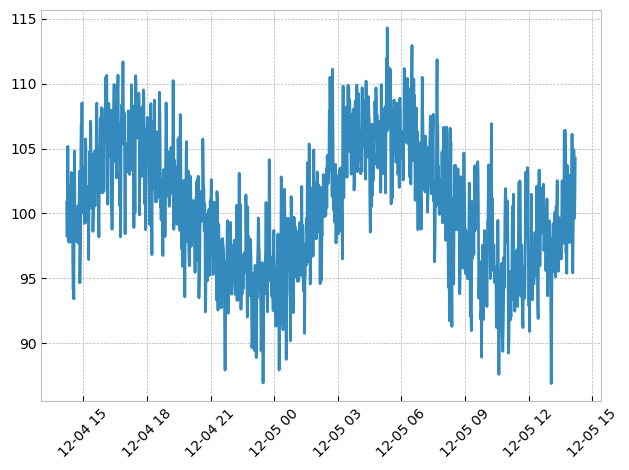

In [51]:
# 시계열 특성 설정 및 조합 [시간단위로 생성]
flat_trend = FlatTrend(value=100)
li_trend = LinearTrend(coefficient=0.05, time_unit=timedelta(hours=1), flat_base=100)
exp_trend = ExponentialTrend(factor=2, time_unit=timedelta(hours=12))
seasonality = SinusoidalSeasonality(amplitude=5, period=timedelta(hours=12))
noise = RedNoise(mean=0, std=3, correlation=0.5)

timeseries = li_trend + seasonality + noise
timeseries.preview_day(num_days=1)

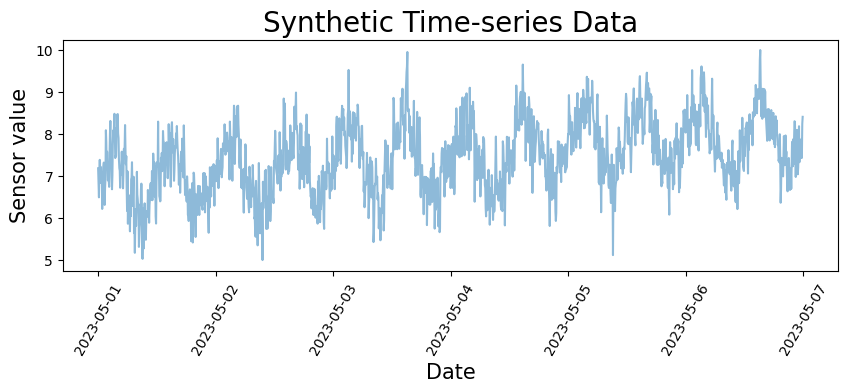

In [81]:
t_unit = 'minutes'                      # 시간단위 : 'microseconds','milliseconds','seconds','minutes','hours','days'
t_unitnum = 5                           # 시간 세분 정도
st_time = datetime(2023, 5, 1)
ed_time = datetime(2023, 5, 7)

min_val = 5
max_val = 10

ts_data_df = get_ts_data_df(timeseries, min_val, max_val, t_unit, t_unitnum, st_time, ed_time)

plt.figure(figsize=(10, 3))
plt.plot(ts_data_df['Timestamp'], ts_data_df['Value'], alpha=0.5)
plt.xlabel("Date",  size = 15)
plt.ylabel("Sensor value", size = 15)
plt.title("Synthetic Time-series Data", size = 20)
plt.xticks(rotation=60)
plt.show()

### 생성된 데이터의 확률밀도함수(분포도) 시각화

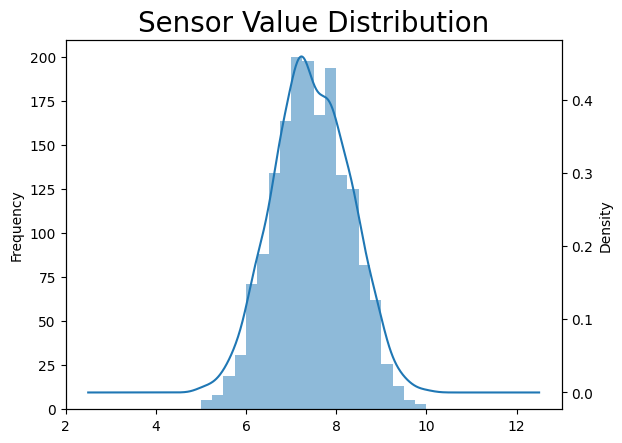

In [82]:
fig, ax = plt.subplots()
ts_data_df['Value'].plot.hist(ax=ax, alpha=0.5, bins=20)
ax2 = ax.twinx()
ts_data_df['Value'].plot.kde(ax=ax2)
ax.set_title("Sensor Value Distribution", size = 20)
plt.show()

### 정상성 제거

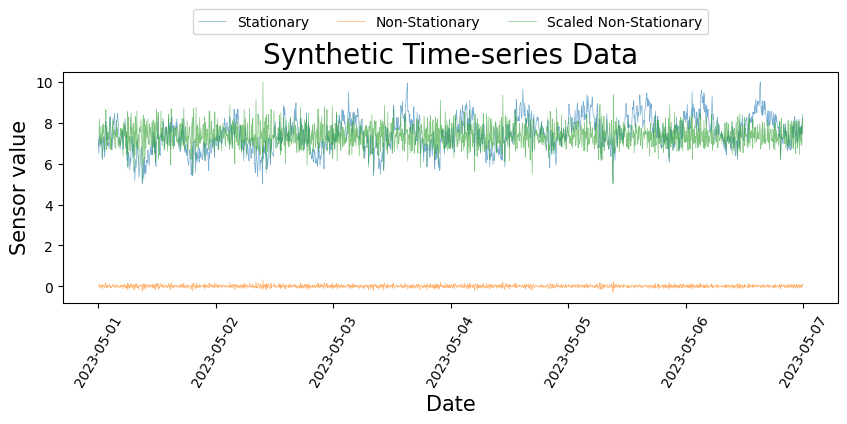

In [83]:
tmp_df = ts_data_df.copy()

tmp_df['Value2'] = tmp_df['Value'].apply(lambda x: np.log(x)).diff(1).dropna()
tmp_df['Value3'] = minMaxScaler(tmp_df['Value2'], tmp_df['Value'].min(), tmp_df['Value'].max())

plt.figure(figsize=(10, 3))
plt.plot(tmp_df['Timestamp'], tmp_df[['Value', 'Value2', 'Value3']], alpha=0.6, linewidth=0.5)
plt.xlabel("Date",  size=15)
plt.ylabel("Sensor value", size=15)
plt.title("Synthetic Time-series Data", size=20)
plt.xticks(rotation=60)
plt.legend(['Stationary', 'Non-Stationary', 'Scaled Non-Stationary'], ncols=3, loc='upper center', bbox_to_anchor=(0, 1., 1., 0.3))
plt.show()

### 계절성 데이터의 수동 생성
- DailySeasonality
- WeeklySeasonality
- YearlySeasonality

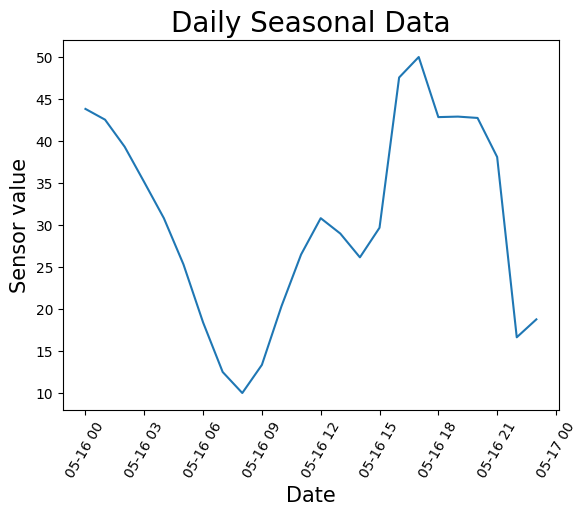

In [185]:
# DailySeasonality, WeeklySeasonality (일시분초... 단위마다 값을 설정할 수 있음)
# timedelta : days, seconds, microseconds, milliseconds, minutes, hours, weeks 단위 조정 가능
# create the daily seasonality signal 
t_unitnum = 1
st_time = datetime(2021, 5, 16)
ed_time = datetime(2021, 5, 17)

min_val = 10
max_val = 50

constraints =  {
    timedelta(hours=0): 75,
    timedelta(hours=4): 50,
    timedelta(hours=8): 10,
    timedelta(hours=10, minutes=50): 40,
    timedelta(hours=12): 50,
    timedelta(hours=14, minutes=30): 40,
    timedelta(hours=16, minutes=30): 90,
    timedelta(hours=18, minutes=30): 10,
    timedelta(hours=18, minutes=30): 70,
    timedelta(hours=19, minutes=20): 75,
    timedelta(hours=21): 64,
    timedelta(hours=22, minutes=30): 10,
}
# daily_seasonality = DailySeasonality(constraints)
# # 곱연산을 위한 정규화
daily_seasonality = DailySeasonality(constraints, normalize=True)

time_points = datetime_range(timedelta(hours=t_unitnum), start_time=st_time, end_time=ed_time)
ts_values = daily_seasonality.generate(time_points=time_points)

ts_data_df = pd.DataFrame()
ts_data_df['Timestamp'] = time_points
# 생성 데이터 범위 조정
ts_data_df['Value'] = minMaxScaler(ts_values, min_val, max_val)

# plt.figure(figsize=(6, 4))
plt.xlabel("Date",  size = 15)
plt.ylabel("Sensor value", size = 15)
plt.title("Daily Seasonal Data", size = 20)
plt.xticks(rotation=60)
plt.plot(ts_data_df['Timestamp'], ts_data_df['Value'])
plt.show()

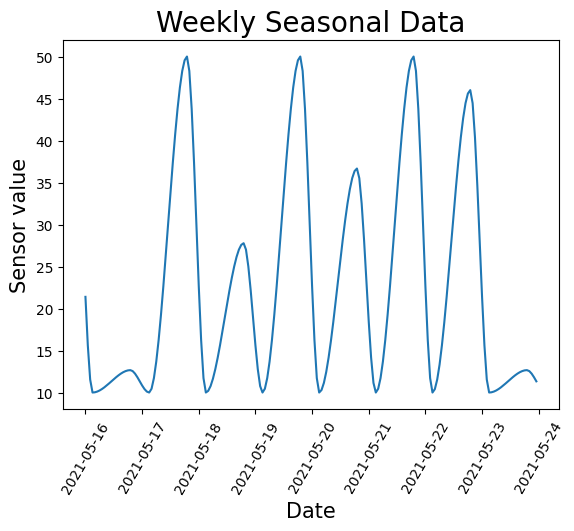

In [183]:
# DailySeasonality, WeeklySeasonality (일시분초... 단위마다 값을 설정할 수 있음)
# timedelta : days, seconds, microseconds, milliseconds, minutes, hours, weeks 단위 조정 가능
# create the daily seasonality signal 
t_unitnum = 1
st_time = datetime(2021, 5, 16)
ed_time = datetime(2021, 5, 24)

min_val = 10
max_val = 50

constraints =  {
    timedelta(hours=3): 10,            ### EARLY MONDAY
    timedelta(hours=19): 100,         ### MONDAY EVENING
    timedelta(days=1, hours=3): 10,    ### EARLY TUESDAY
    timedelta(days=1, hours=19): 50, ### TUESDAY EVENING
    timedelta(days=2, hours=3): 10,    ### EARLY WEDNESDAY
    timedelta(days=2, hours=19): 100, ### WEDNESDAY EVENING
    timedelta(days=3, hours=3): 10,    ### EARLY THURSDAY
    timedelta(days=3, hours=19): 70, ### THURSDAY EVENING
    timedelta(days=4, hours=3): 10,    ### EARLY FRIDAY
    timedelta(days=4, hours=19): 100, ### FRIDAY EVENING
    timedelta(days=5, hours=3): 10,    ### EARLY SATURDAY
    timedelta(days=5, hours=19): 91,  ### SATURDAY EVENING
    timedelta(days=6, hours=3): 10,    ### EARLY SUNDAY
    timedelta(days=6, hours=19): 16,  ### SUNDAY EVENING
}
# weekly_seasonality = WeeklySeasonality(constraints)
# # 곱연산을 위한 정규화
weekly_seasonality = WeeklySeasonality(constraints, normalize=True)

time_points = datetime_range(timedelta(hours=t_unitnum), start_time=st_time, end_time=ed_time)
ts_values = weekly_seasonality.generate(time_points=time_points)

ts_data_df = pd.DataFrame()
ts_data_df['Timestamp'] = time_points
# 생성 데이터 범위 조정
ts_data_df['Value'] = minMaxScaler(ts_values, min_val, max_val)

# plt.figure(figsize=(6, 4))
plt.xlabel("Date",  size = 15)
plt.ylabel("Sensor value", size = 15)
plt.title("Weekly Seasonal Data", size = 20)
plt.xticks(rotation=60)
plt.plot(ts_data_df['Timestamp'], ts_data_df['Value'])
plt.show()

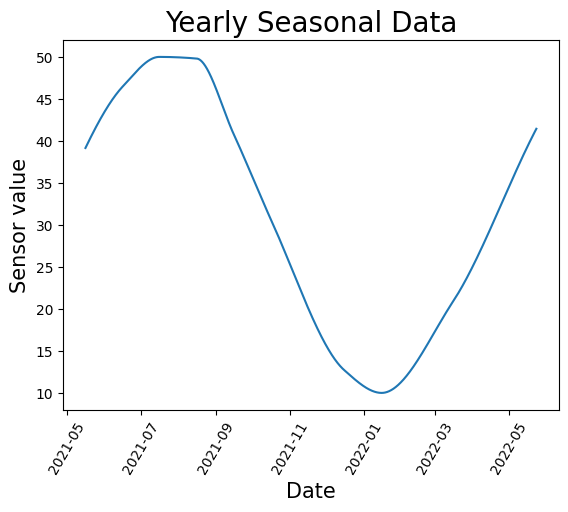

In [184]:
# DailySeasonality, WeeklySeasonality (일시분초... 단위마다 값을 설정할 수 있음)
# timedelta : days, seconds, microseconds, milliseconds, minutes, hours, weeks 단위 조정 가능
# create the daily seasonality signal 
t_unitnum = 1
st_time = datetime(2021, 5, 16)
ed_time = datetime(2022, 5, 24)

min_val = 10
max_val = 50

# YearlySeasonality
constraints = {
        JANUARY: 1.3,
        MARCH: 6.9,
        JUNE: 20.1,
        JULY: 21.9,
        AUGUST: 21.8,
        SEPTEMBER: 17.1,
        OCTOBER: 12,
        DECEMBER: 2.7,
    }
# yearly_seasonality = YearlySeasonality(constraints)
# # 곱연산을 위한 정규화
yearly_seasonality = YearlySeasonality(constraints, normalize=True)

time_points = datetime_range(timedelta(hours=t_unitnum), start_time=st_time, end_time=ed_time)
ts_values = yearly_seasonality.generate(time_points=time_points)

ts_data_df = pd.DataFrame()
ts_data_df['Timestamp'] = time_points
# 생성 데이터 범위 조정
ts_data_df['Value'] = minMaxScaler(ts_values, min_val, max_val)

# plt.figure(figsize=(6, 4))
plt.xlabel("Date",  size = 15)
plt.ylabel("Sensor value", size = 15)
plt.title("Yearly Seasonal Data", size = 20)
plt.xticks(rotation=60)
plt.plot(ts_data_df['Timestamp'], ts_data_df['Value'])
plt.show()